In [1]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

import vae
import data

# Use LaTeX-style formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12
})

plt.rcParams["figure.dpi"] = 300  # High resolution

plt.rcParams["font.family"] = "serif"  # Use serif font
plt.rcParams["axes.linewidth"] = 1.5  # Thicker axis lines
plt.rcParams["xtick.direction"] = "in"  # Ticks inside the plot
plt.rcParams["ytick.direction"] = "in"

In [2]:
# Creates shape random shape data.
shape_data = data.Generator(resolution=200,num_shapes=100000).generate_shapes()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:05<00:00, 17815.64it/s]


In [ ]:

# Creates PyTorch dataset.
dataset = vae.ShapeData(shape_data)

# Build VAE Model.
model = vae.VAE(200*2,2)

# Initialises model trainer.
trainer = vae.Trainer(dataset,model,model_name='model005',lr=1e-3,batch_size=1024,loss='mse')
trainer.train_model(10)

In [22]:
torch.save(model,r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/models/model003.pt')

In [23]:
test_shapes = data.Generator(resolution=200,num_shapes=10).generate_shapes()

dt = [torch.tensor(shape.points, dtype=torch.float32).view(-1) for shape in test_shapes]

100%|██████████| 10/10 [00:00<00:00, 3805.05it/s]


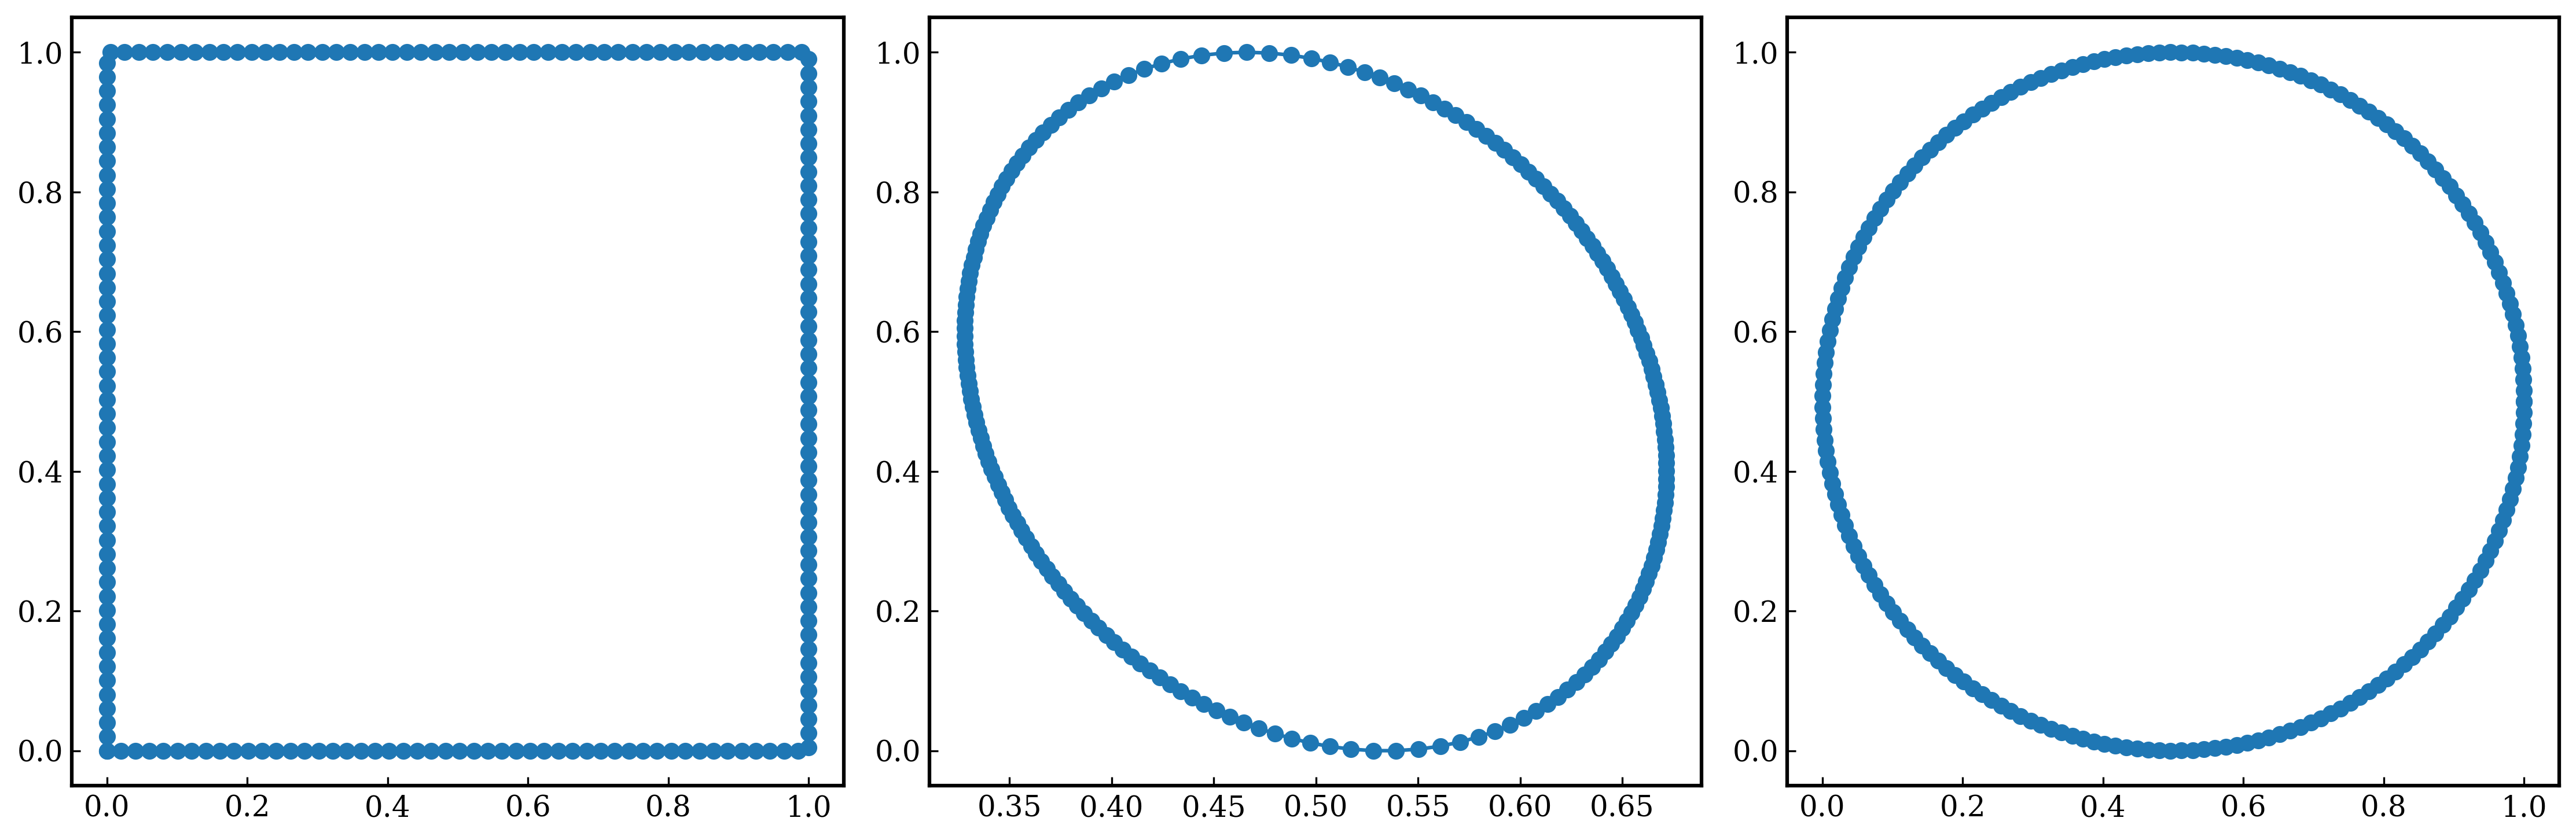

In [24]:
# Plot 3 random shapes side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle('Random Shape Examples', fontsize=14)

# Get 3 random indices
random_indices = np.random.choice(len(dt), size=3, replace=False)

for idx, ax in enumerate(axes):
    # Get random shape and reshape to 2D coordinates
    shape = dt[random_indices[idx]]  # This should give us a tensor of shape (1,400)
    
    orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
    ax.plot(orig_shape[:, 0], orig_shape[:, 1], 'o-', label="Original")
    

    
plt.tight_layout()
plt.show()

In [25]:
x = model.encoder(dt[0])  # Encoder block.
mu,logvar = model.fc_mu(x),model.fc_logvar(x)  # Mu & Logvar for latent layer.
z = model.reparameterise(mu,logvar)  # Obtain latent variables.
print(z)  # Z is differet each time due to the random sampling of epsilon.

tensor([-0.2671,  1.0914], grad_fn=<AddBackward0>)


(200, 2)


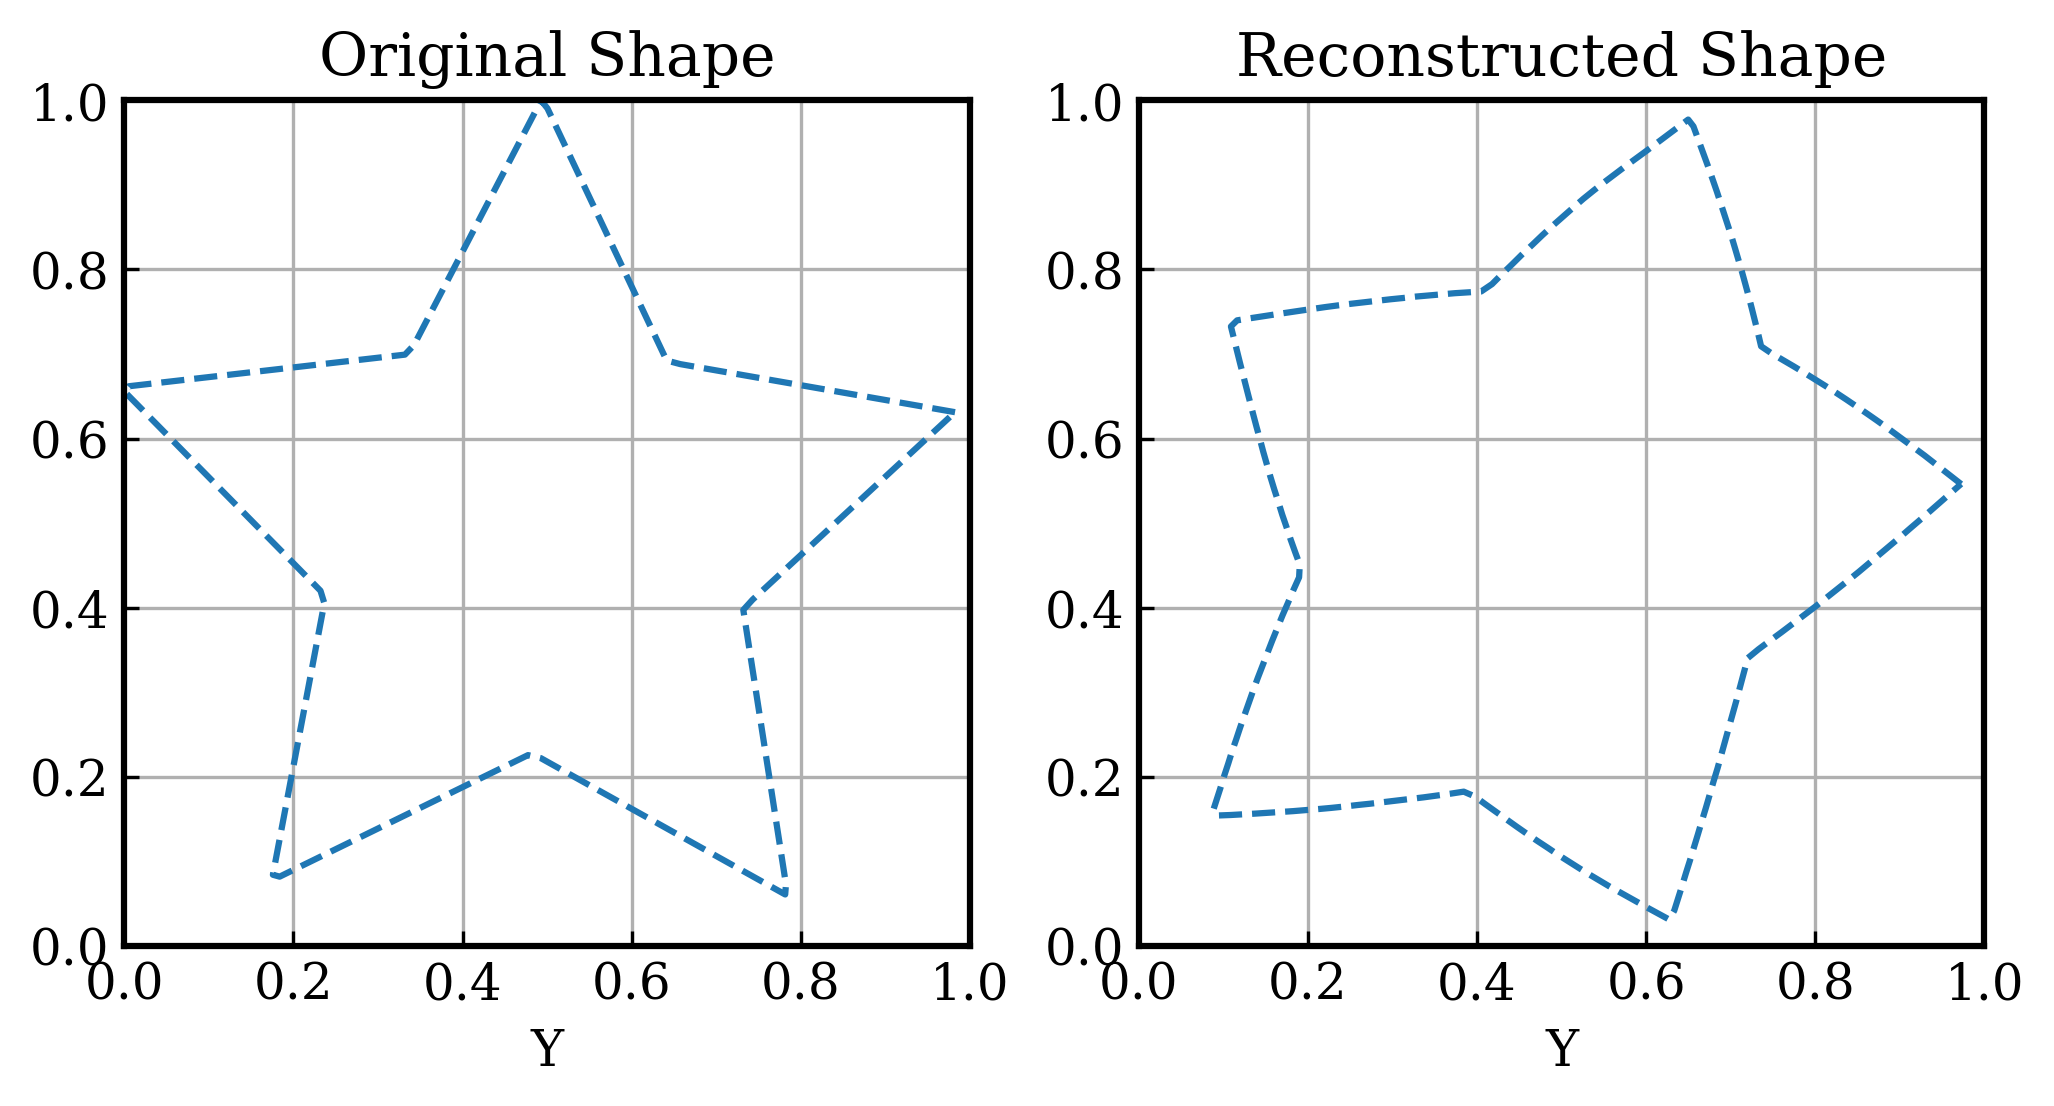

(200, 2)


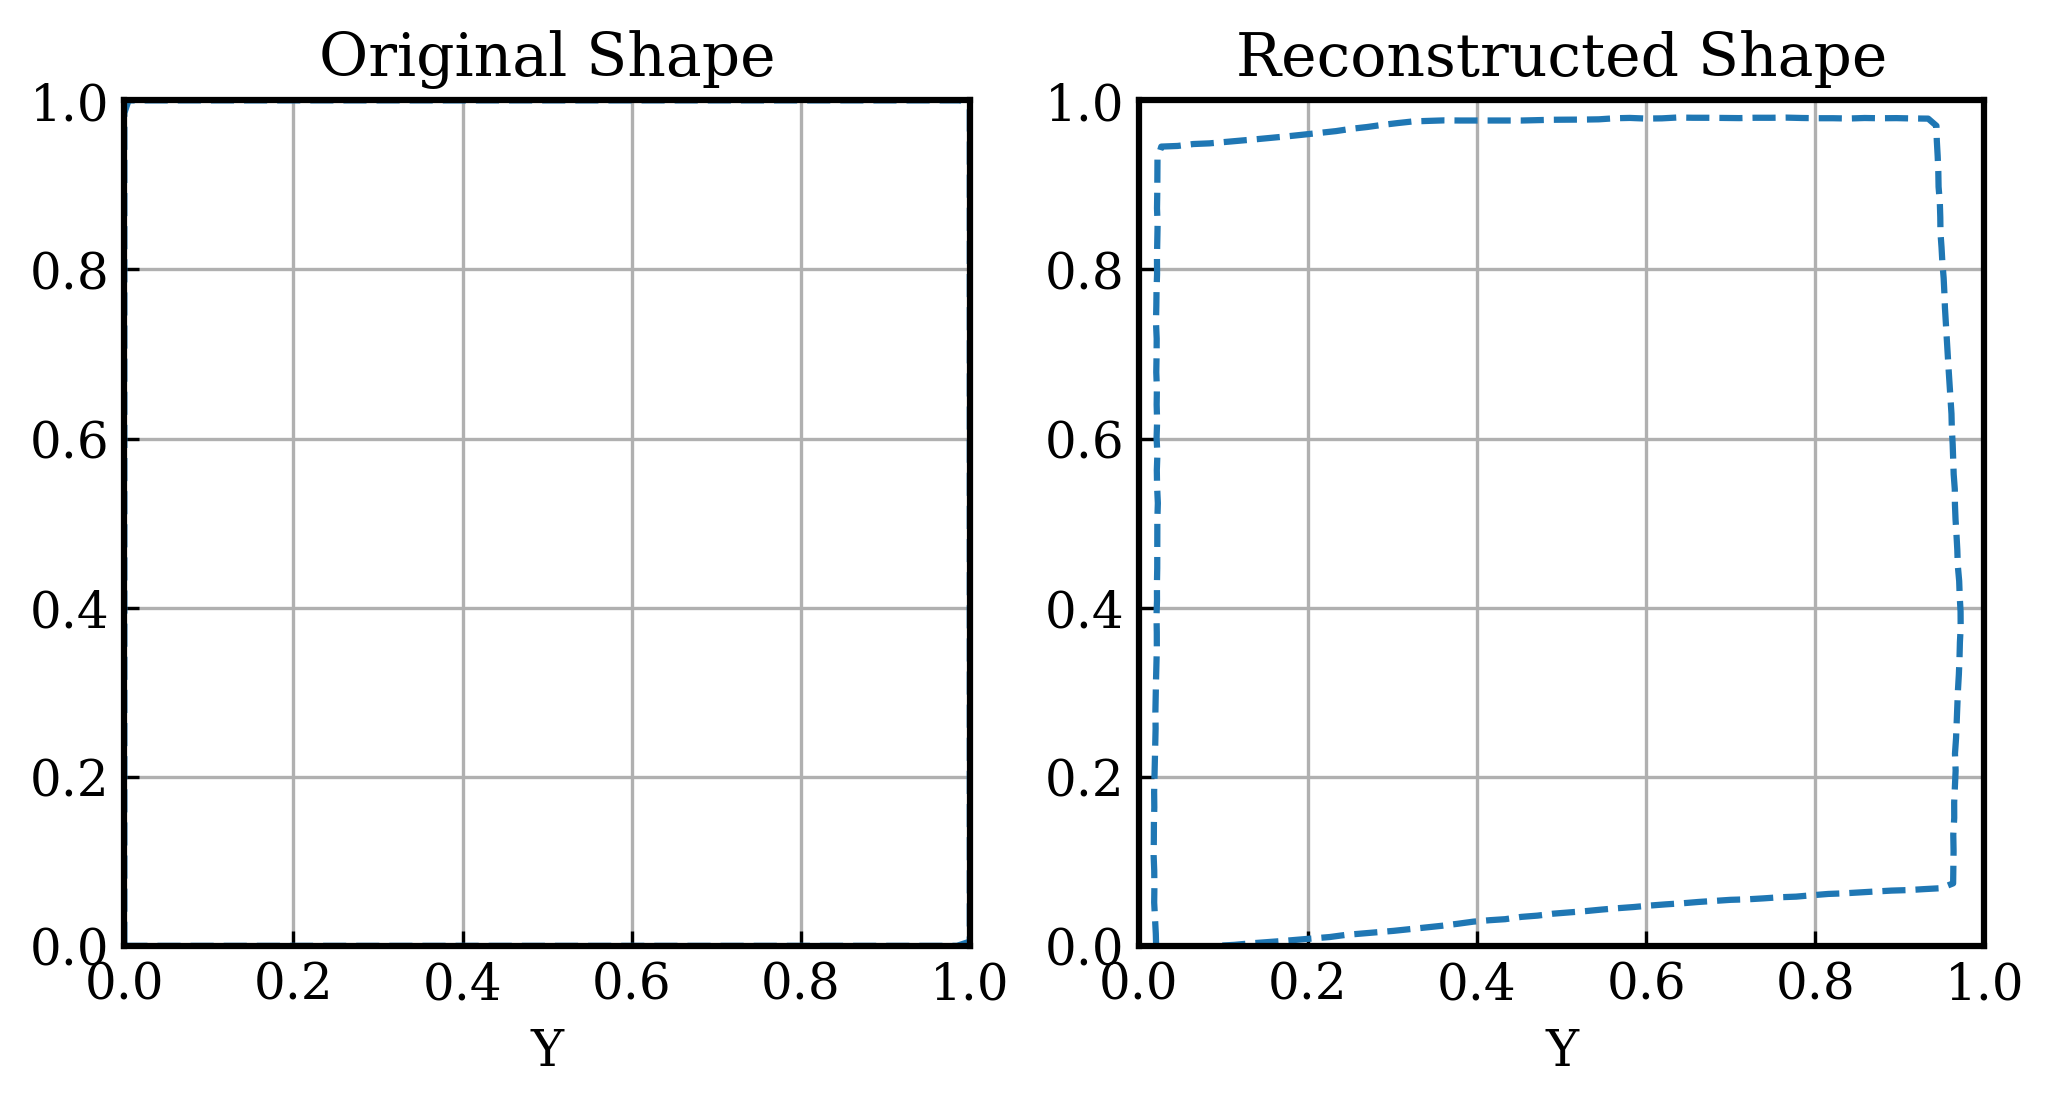

(200, 2)


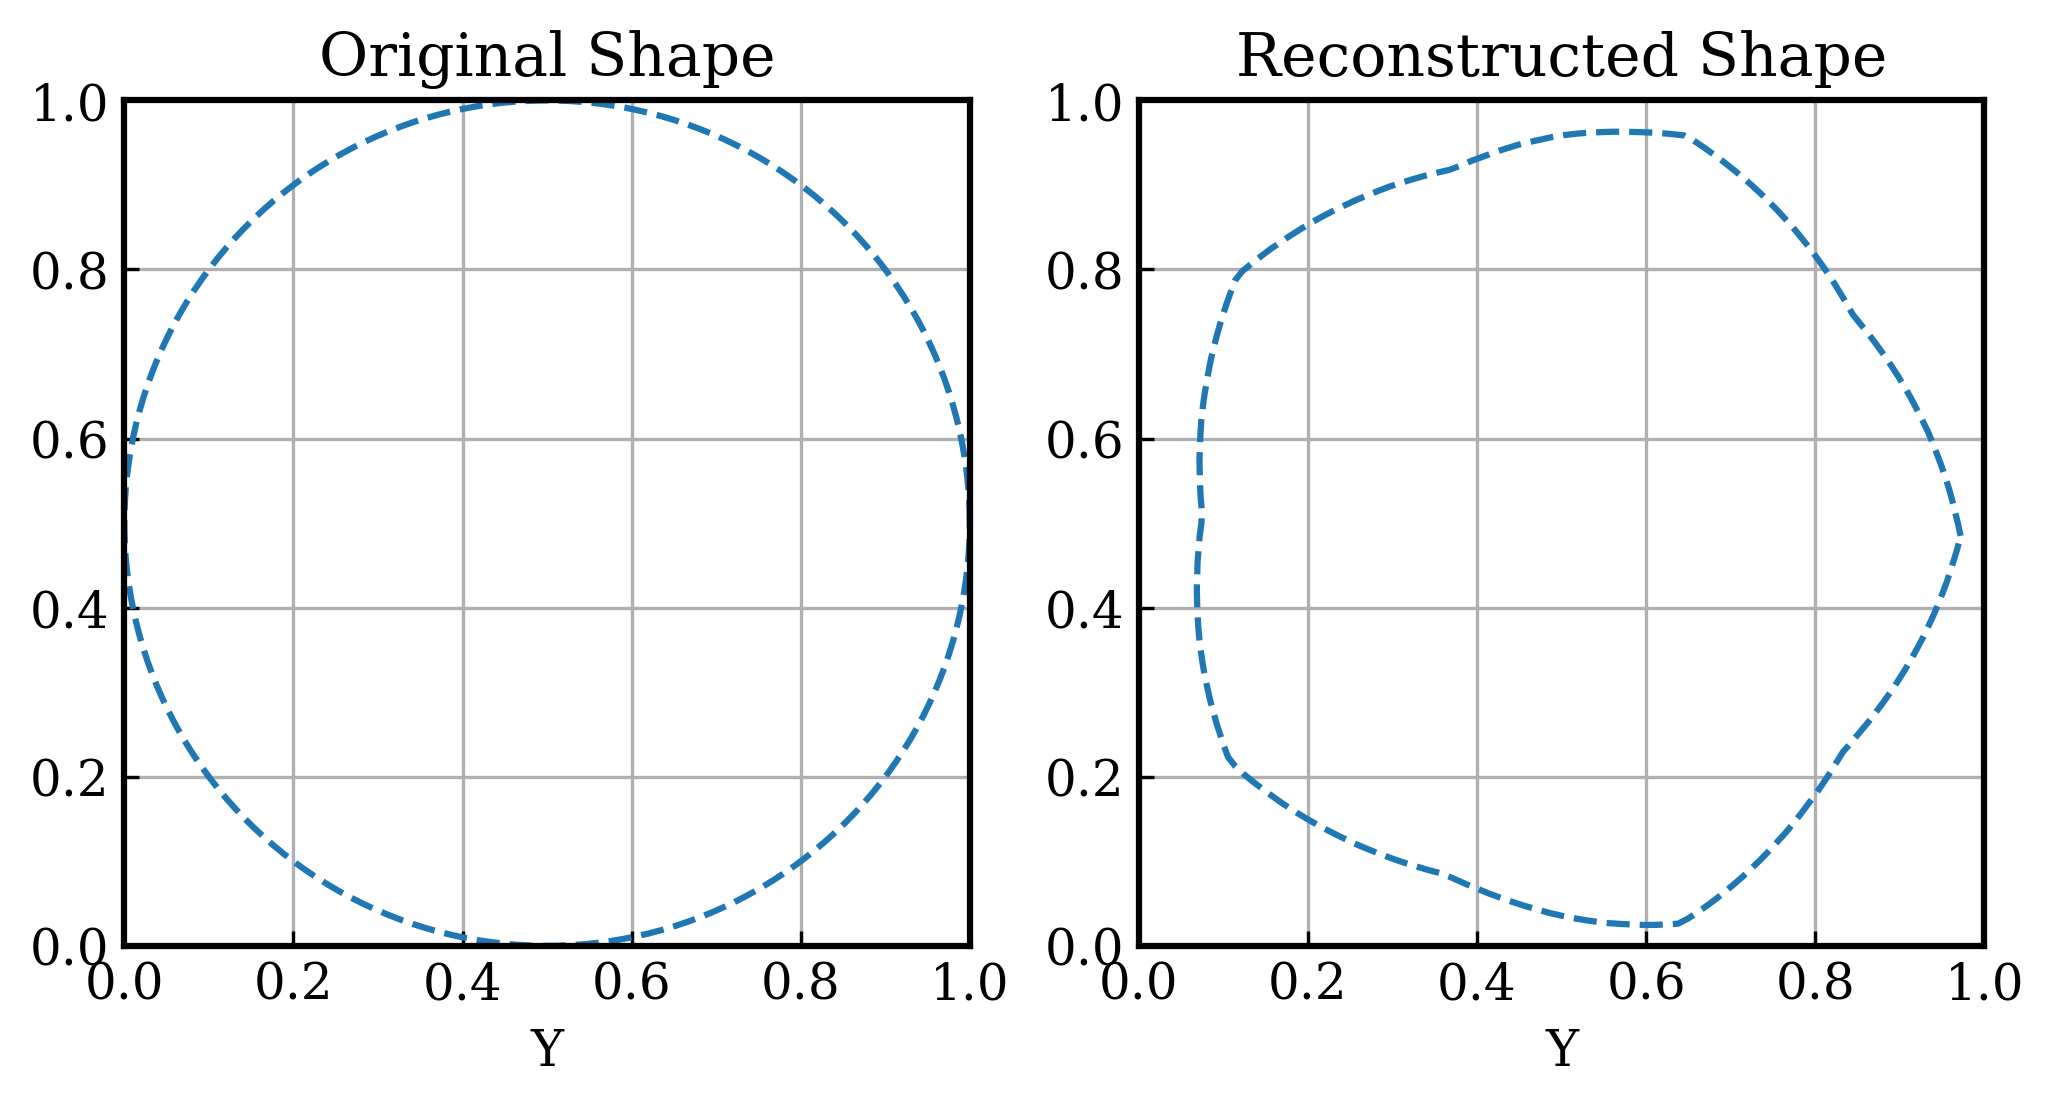

(200, 2)


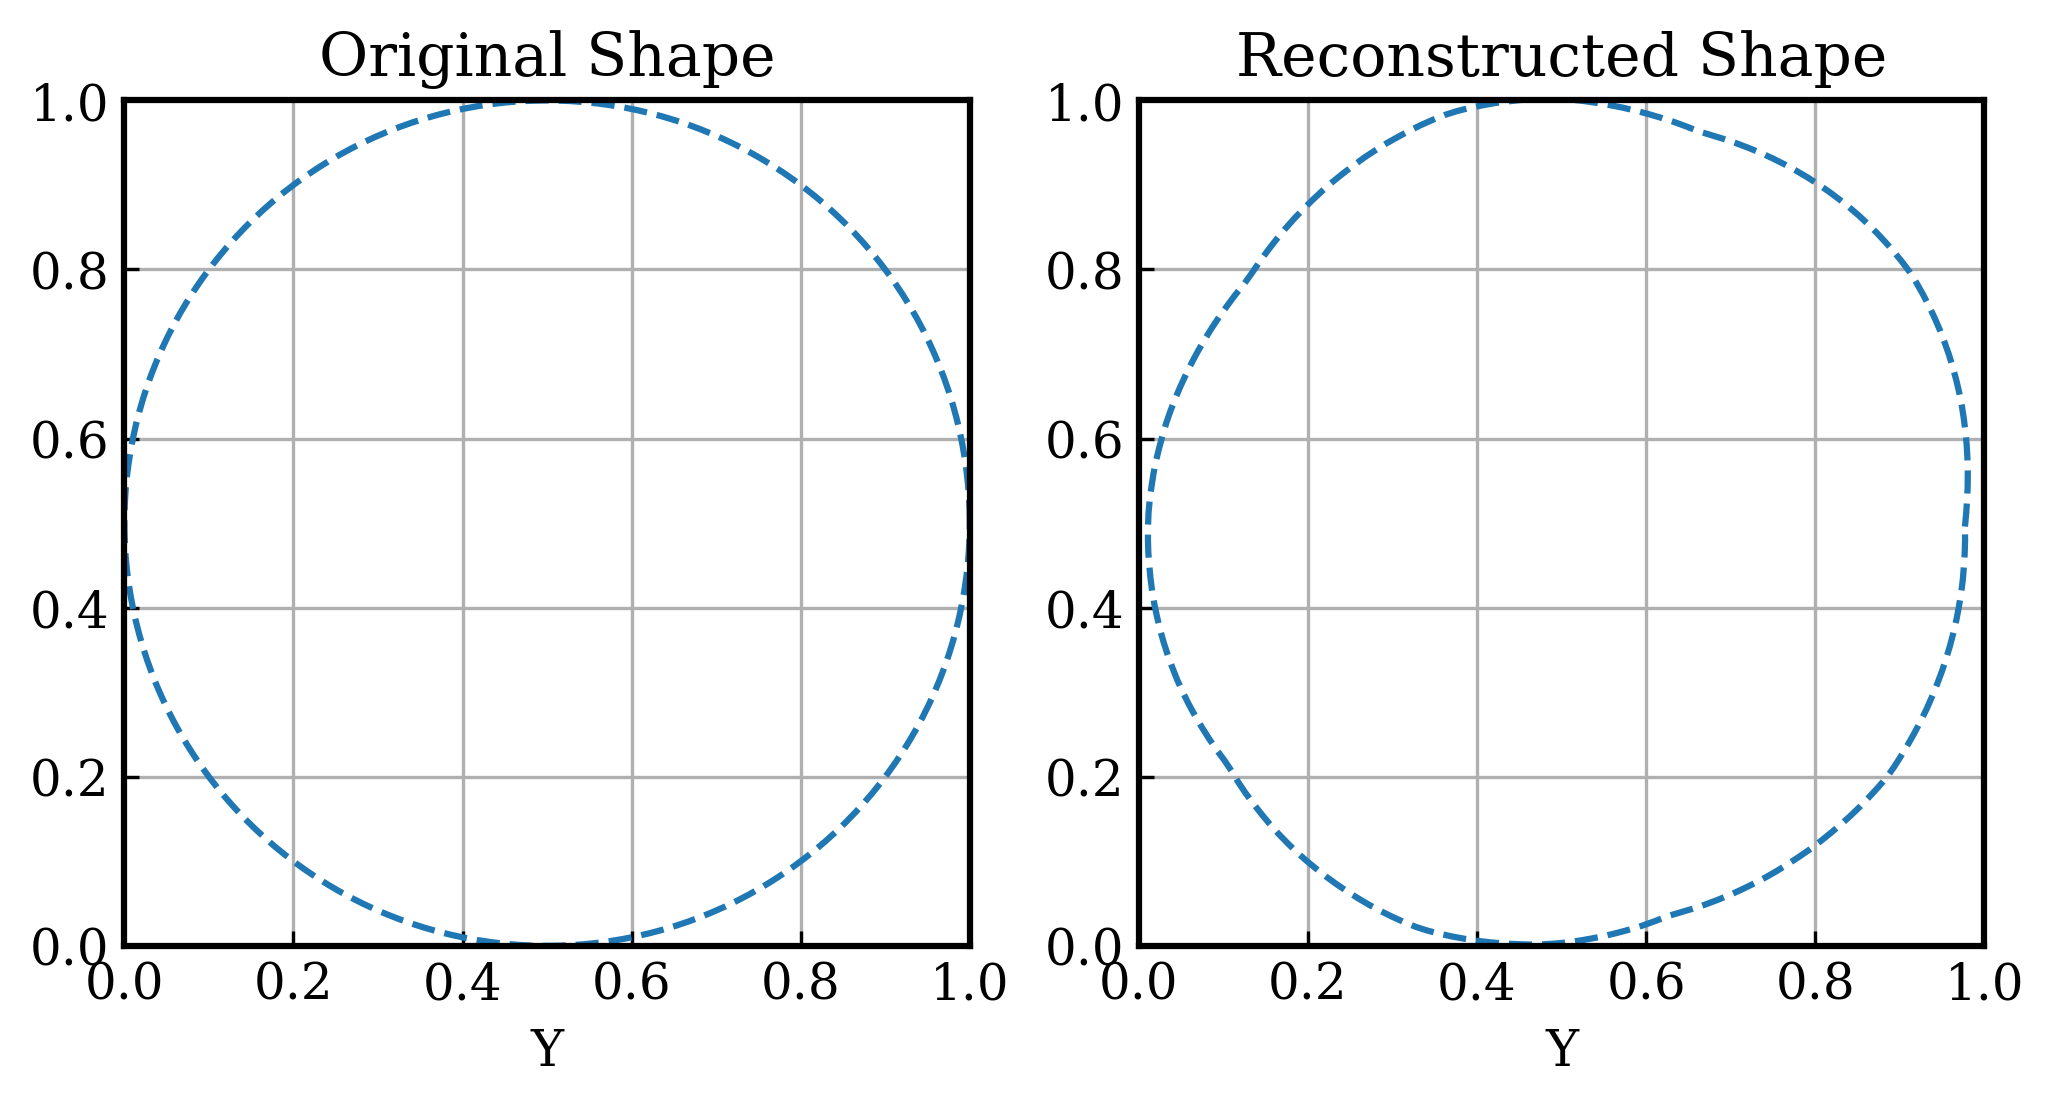

(200, 2)


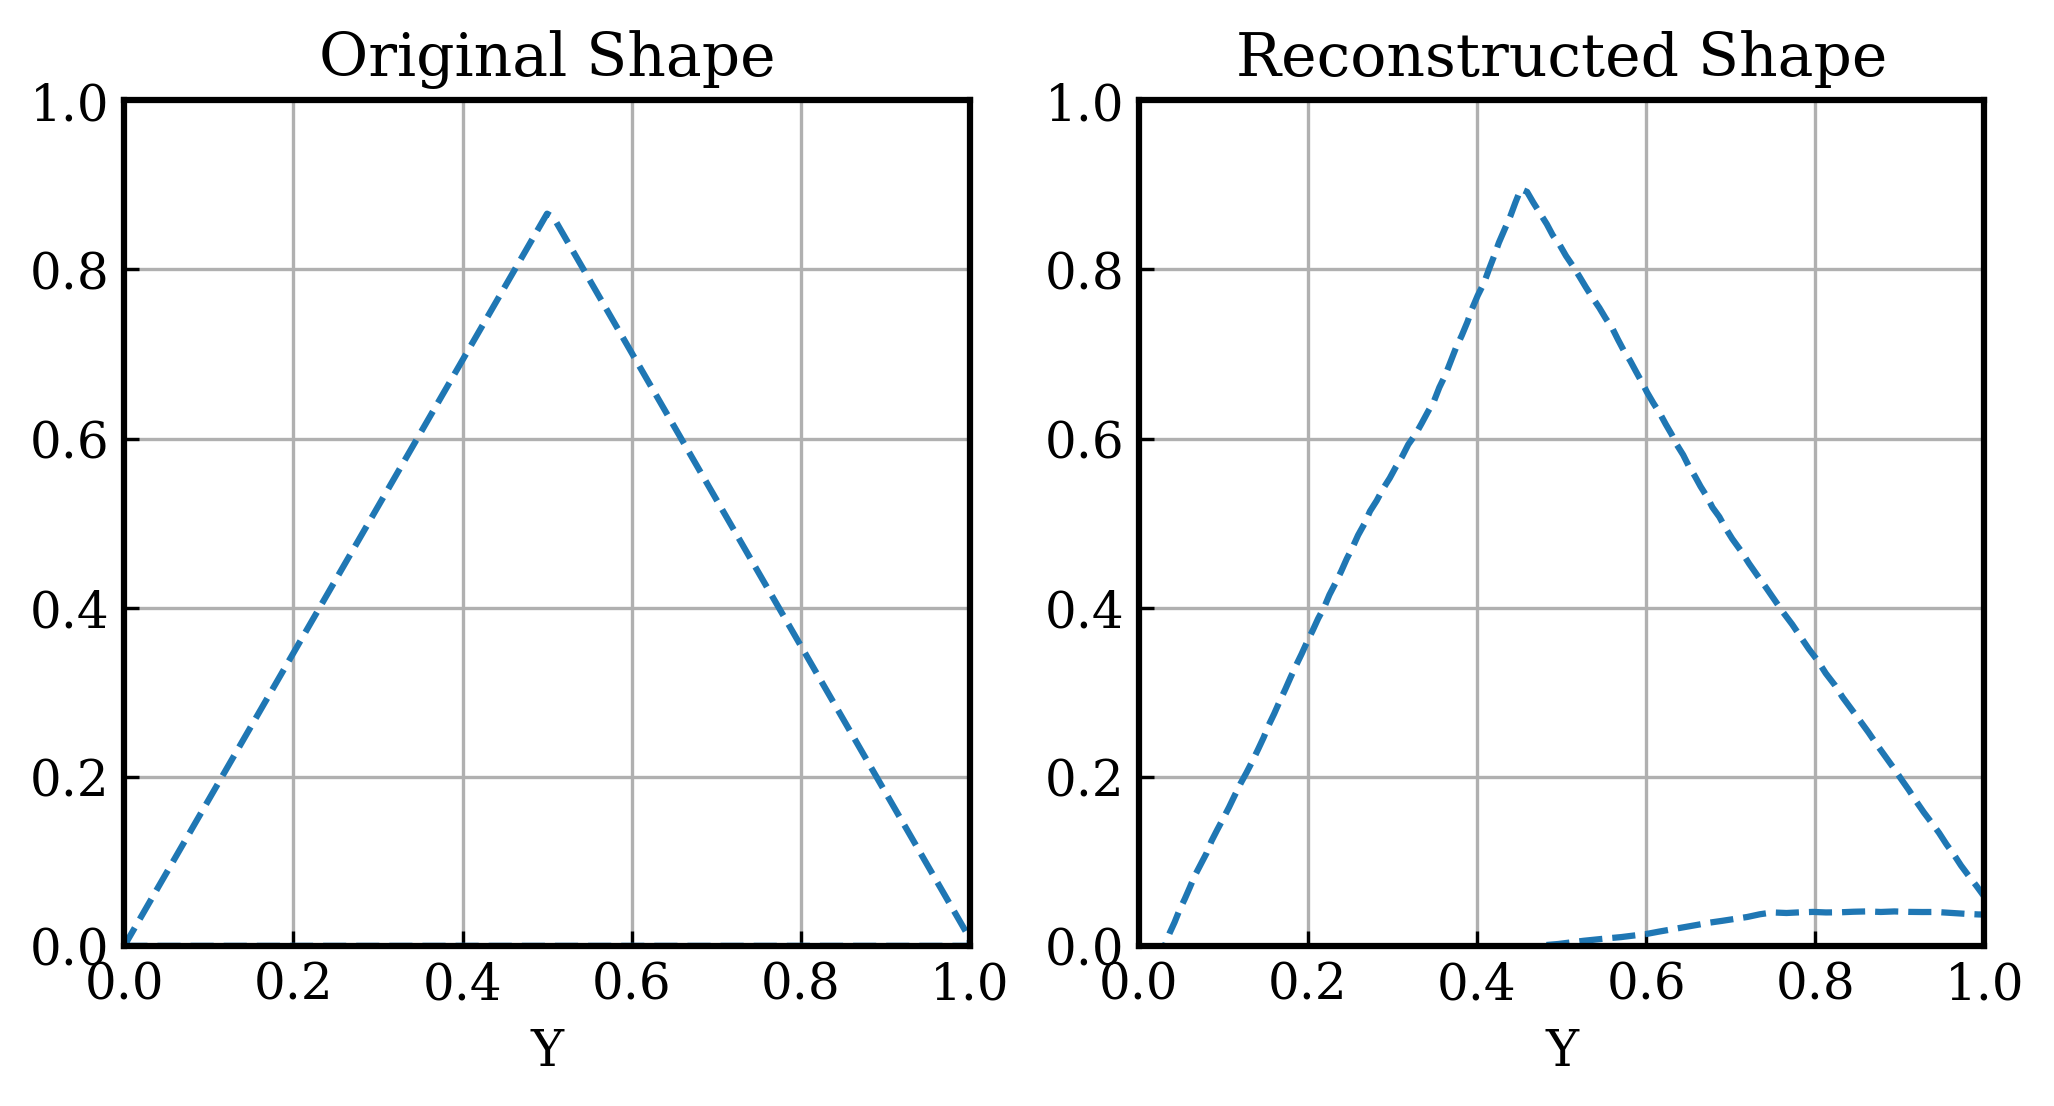

(200, 2)


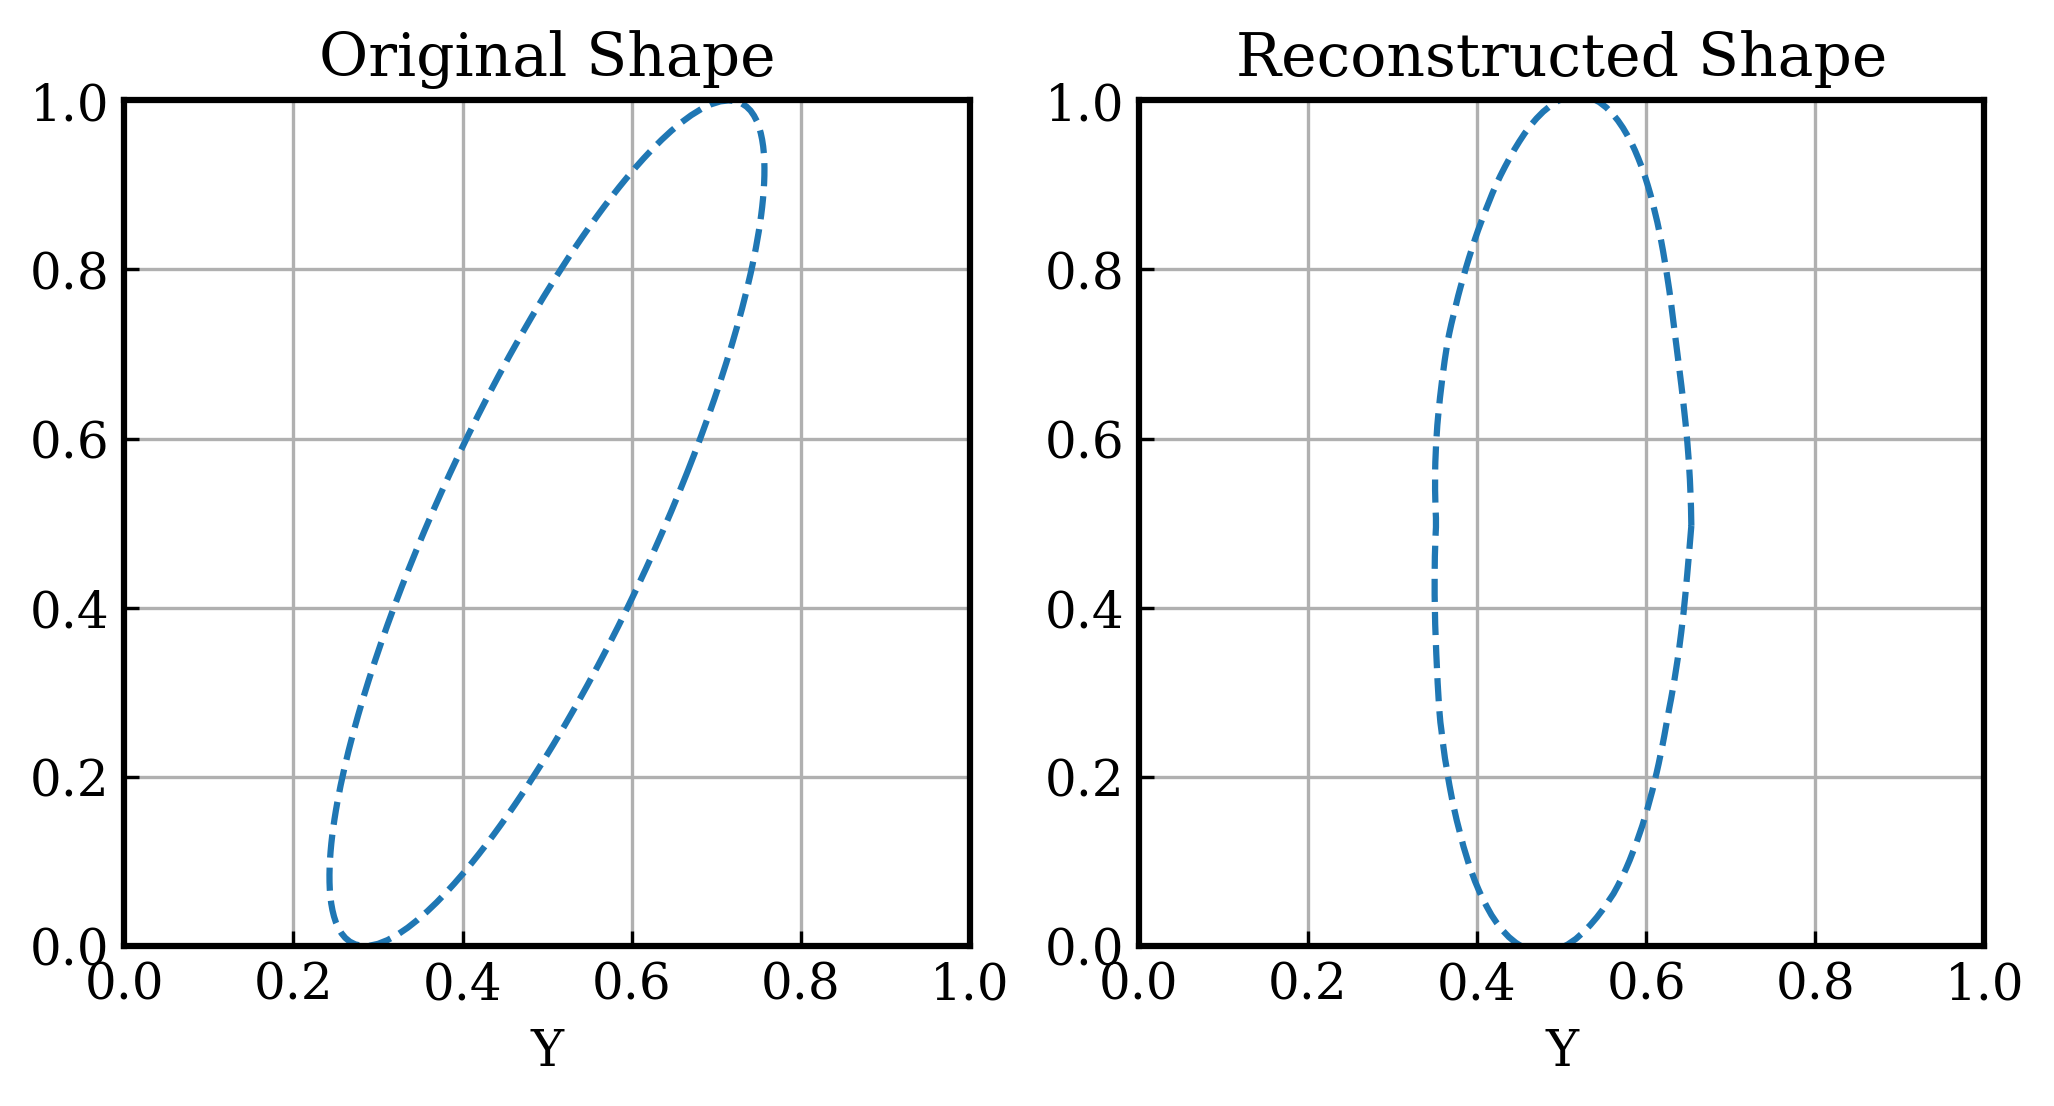

(200, 2)


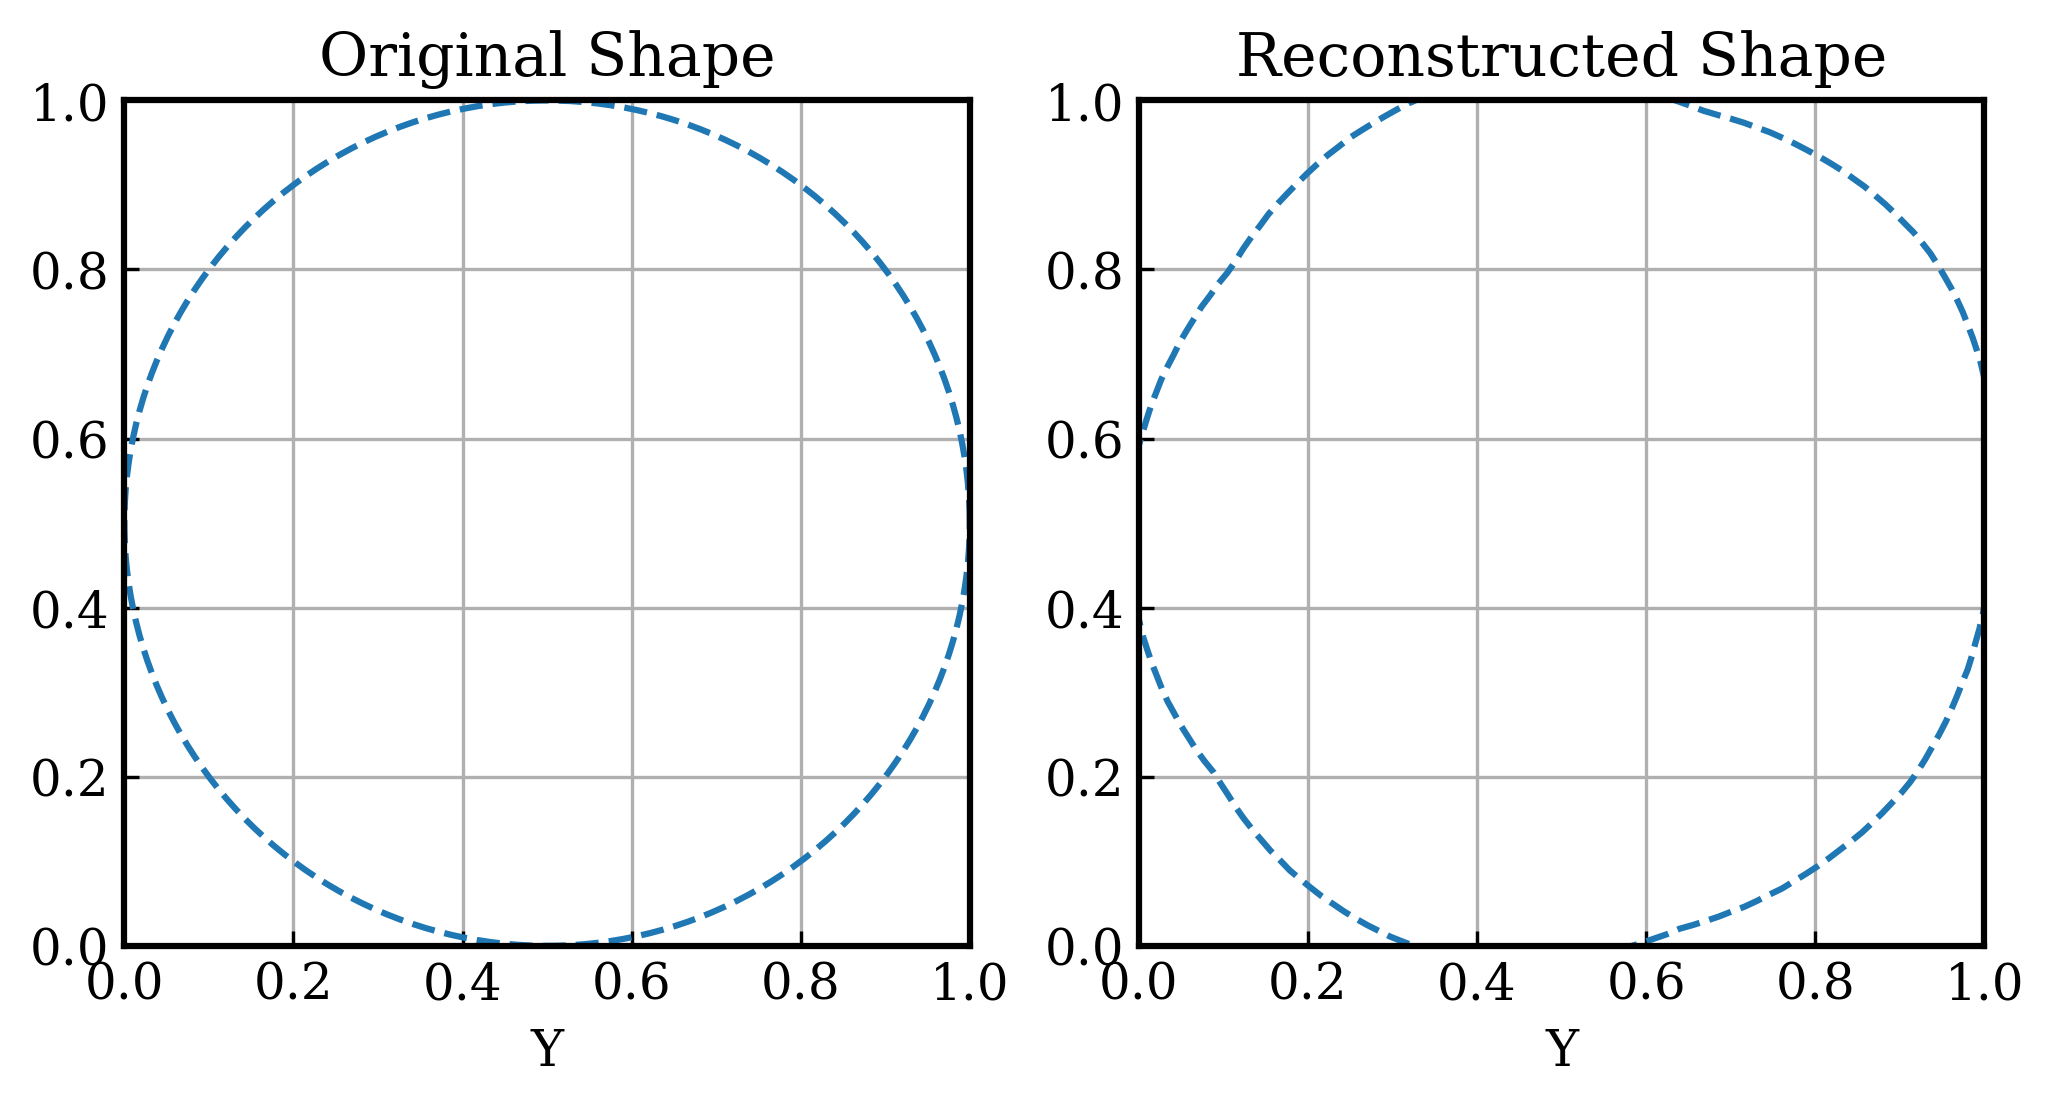

(200, 2)


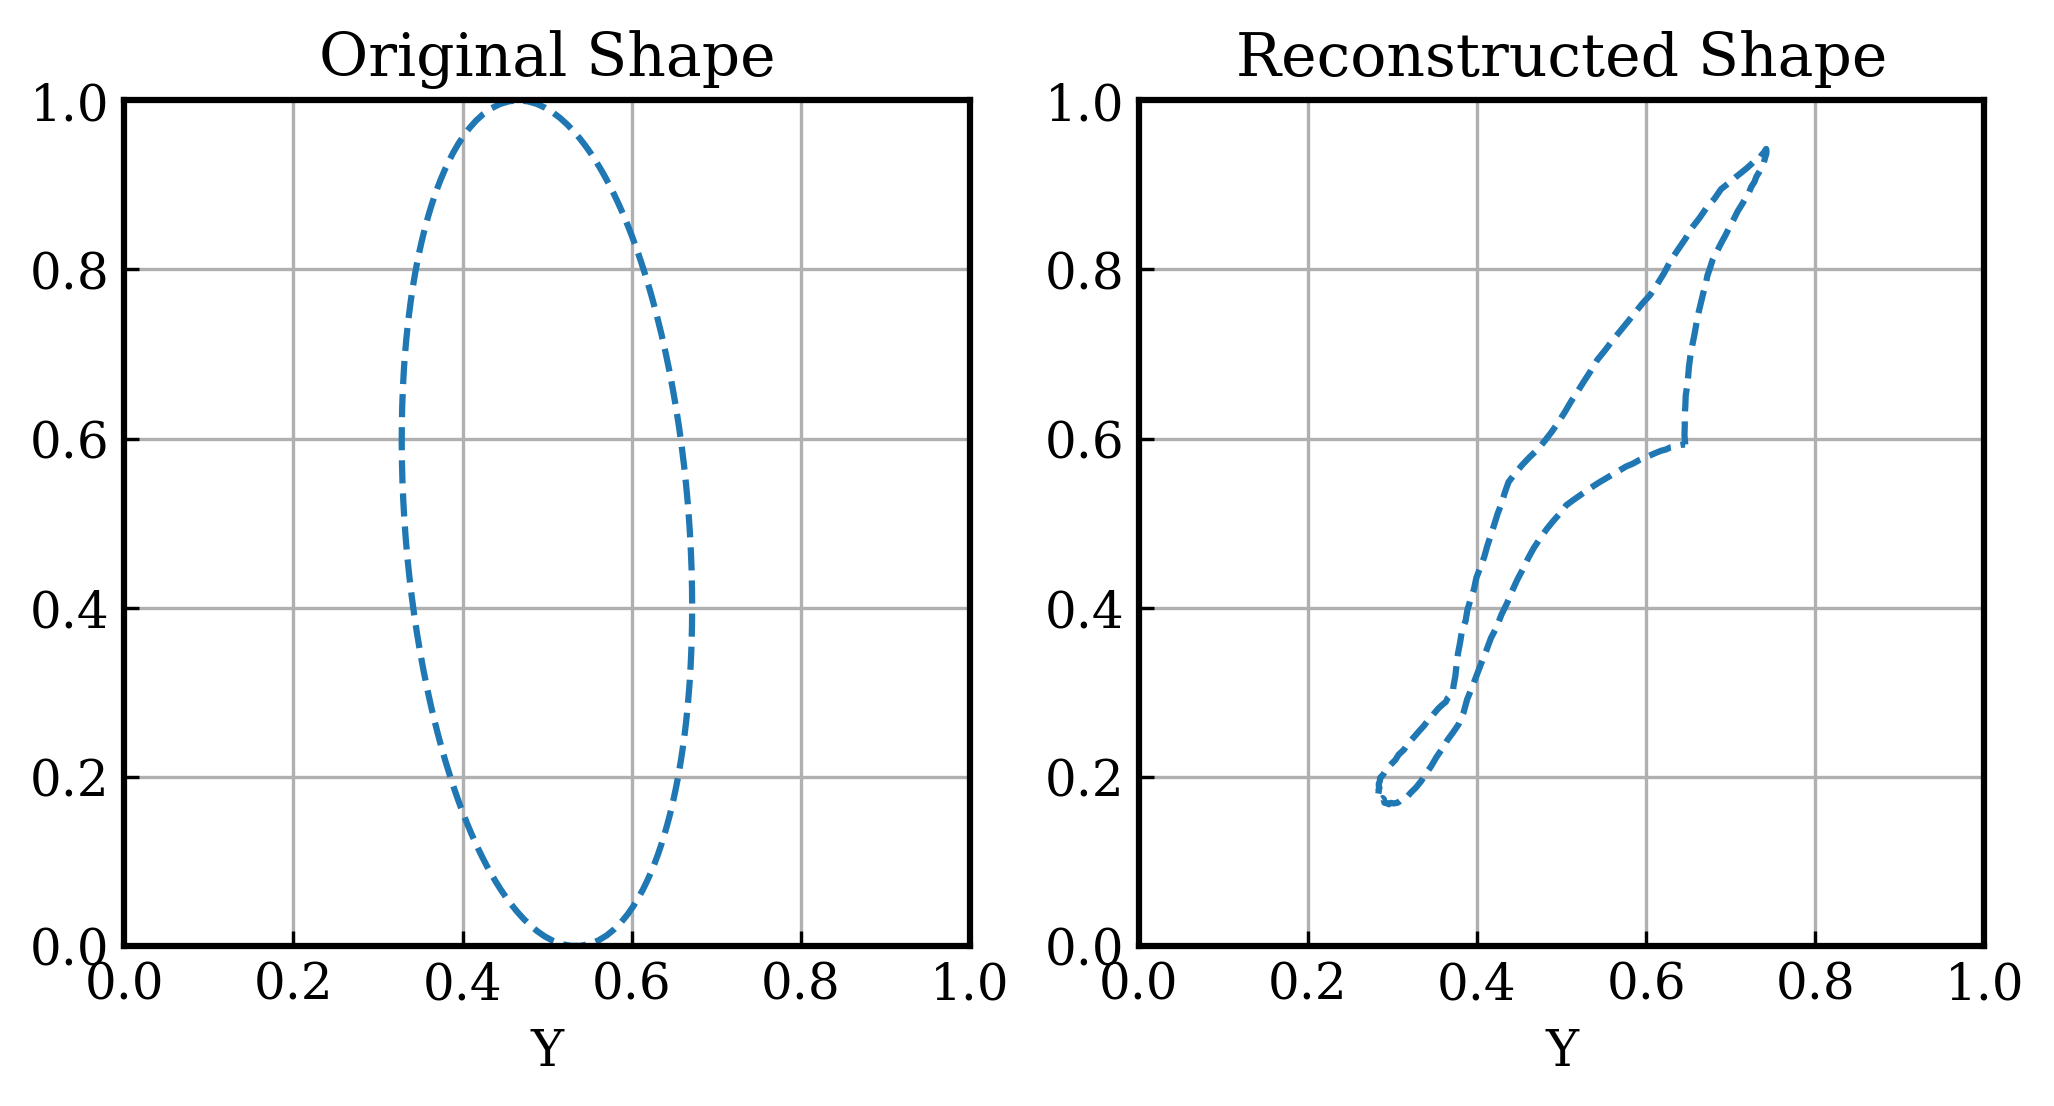

(200, 2)


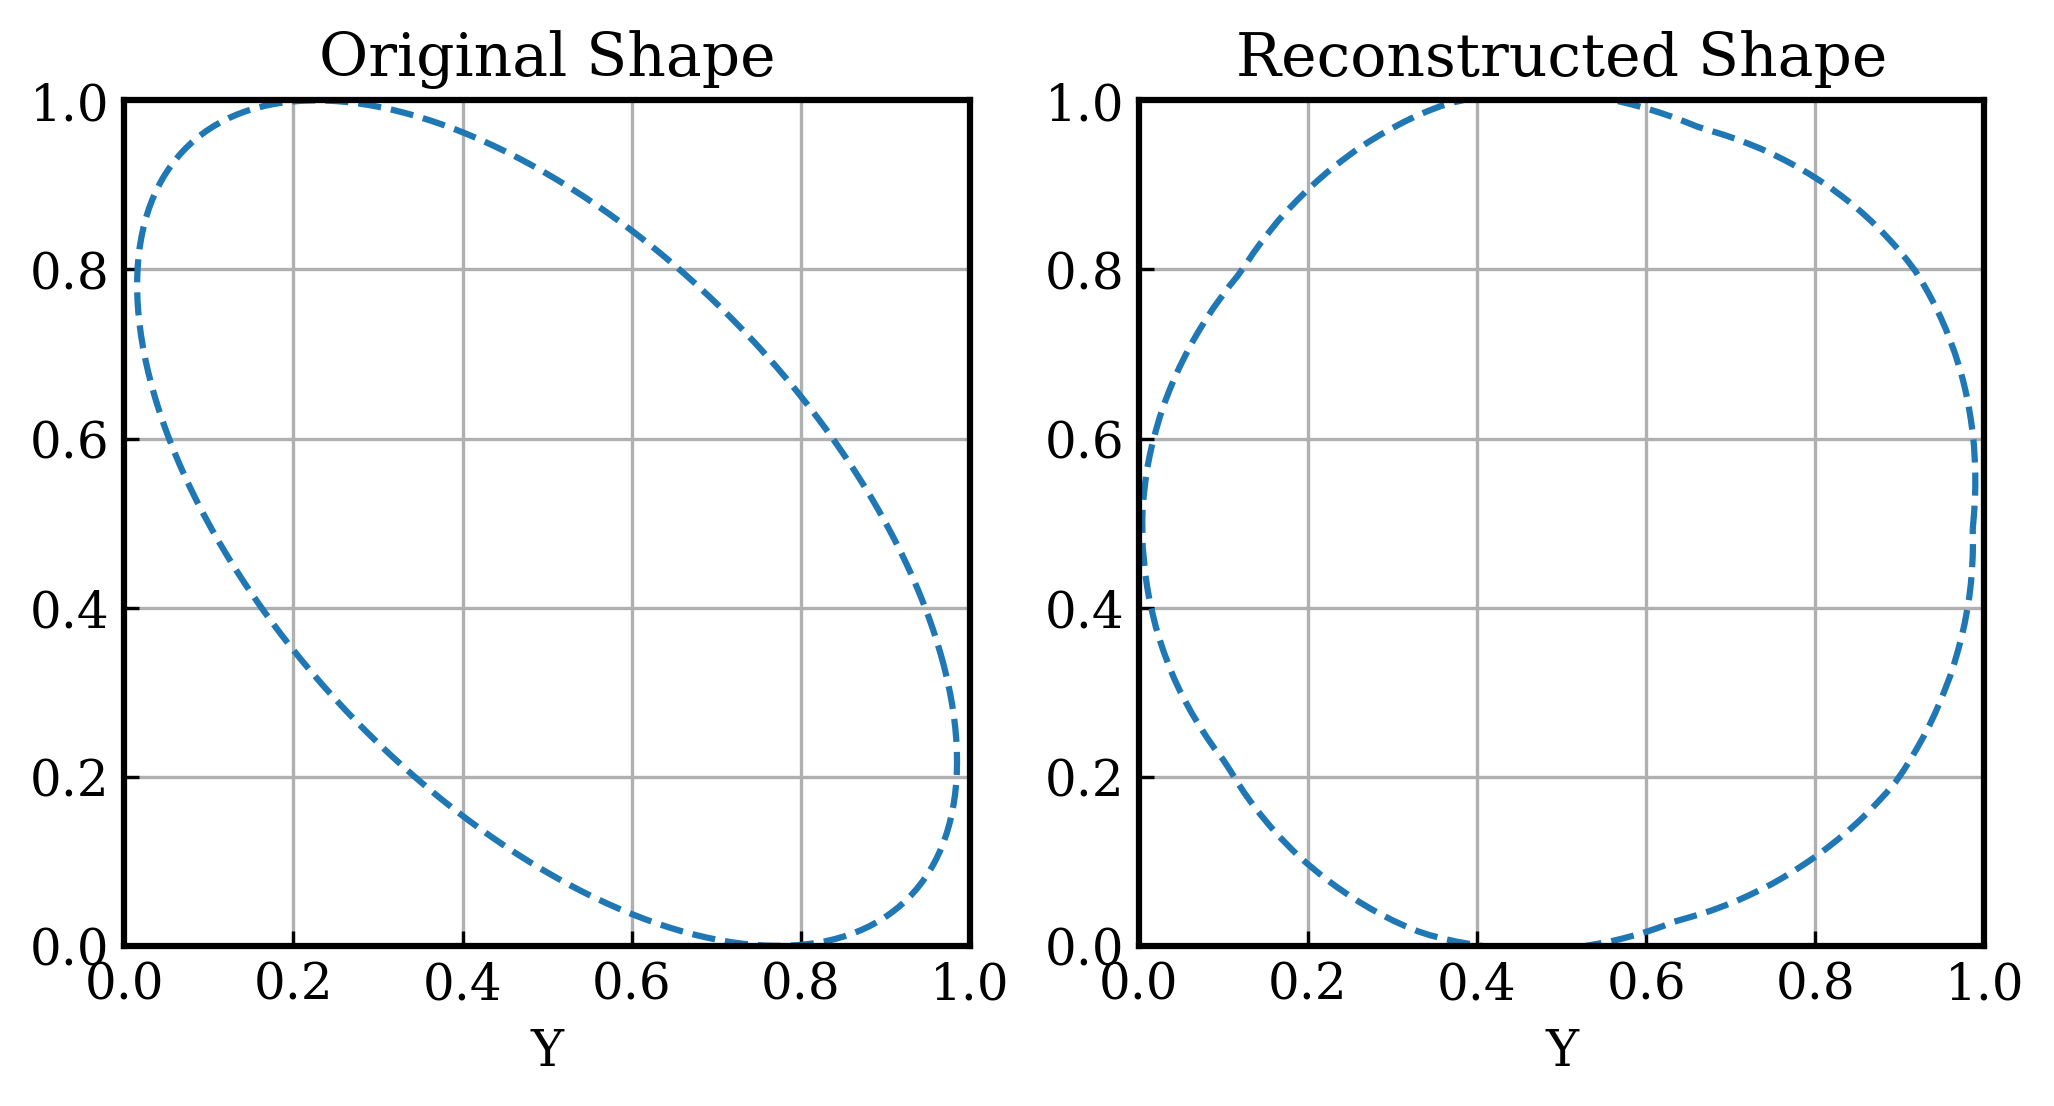

(200, 2)


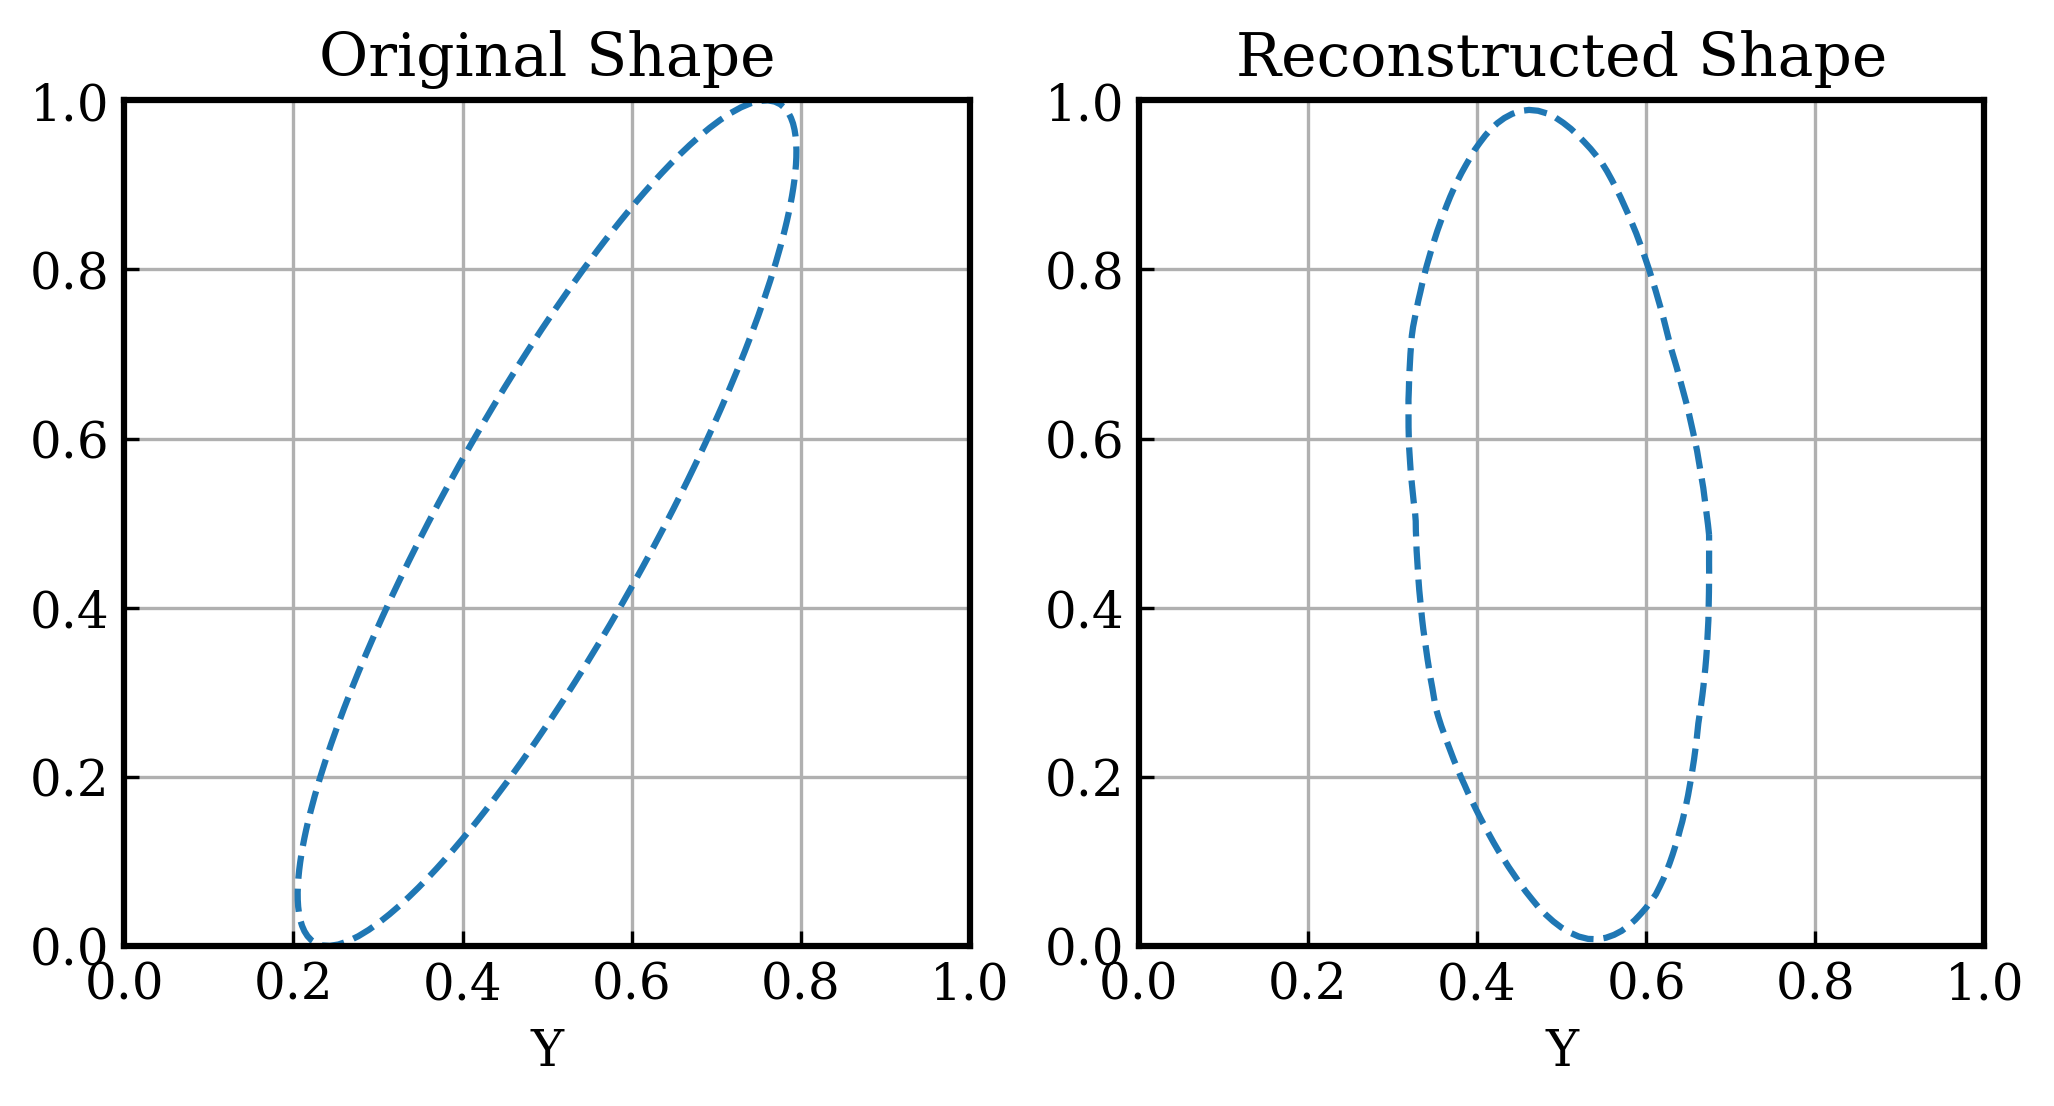

In [26]:
model.eval()

# Pass through VAE
with torch.no_grad():
    for shape in dt:
        
        recon_shape, mu, log_var = model(shape)
        recon_shape = recon_shape.squeeze(0).numpy().reshape(-1,2)

        orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
        print(orig_shape.shape)
        # Plot Original vs. Reconstructed
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        for ax in axs:
            ax.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
            ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1
            ax.set_aspect('equal')  # Ensure square aspect ratio
            ax.grid(True)  # Optional: Add a grid for better visualization

        axs[0].plot(orig_shape[:, 0], orig_shape[:, 1], '--', label="Original")
        axs[0].set_title("Original Shape")
        axs[0].set_xlabel('X')
        axs[0].set_xlabel('Y')
        axs[0].set_aspect('equal')

        axs[1].plot(recon_shape[:, 0], recon_shape[:, 1],'--', label="Reconstructed",markersize = 1)
        axs[1].set_title("Reconstructed Shape")
        axs[1].set_xlabel('X')
        axs[1].set_xlabel('Y')
        axs[1].set_aspect('equal')

        plt.show()



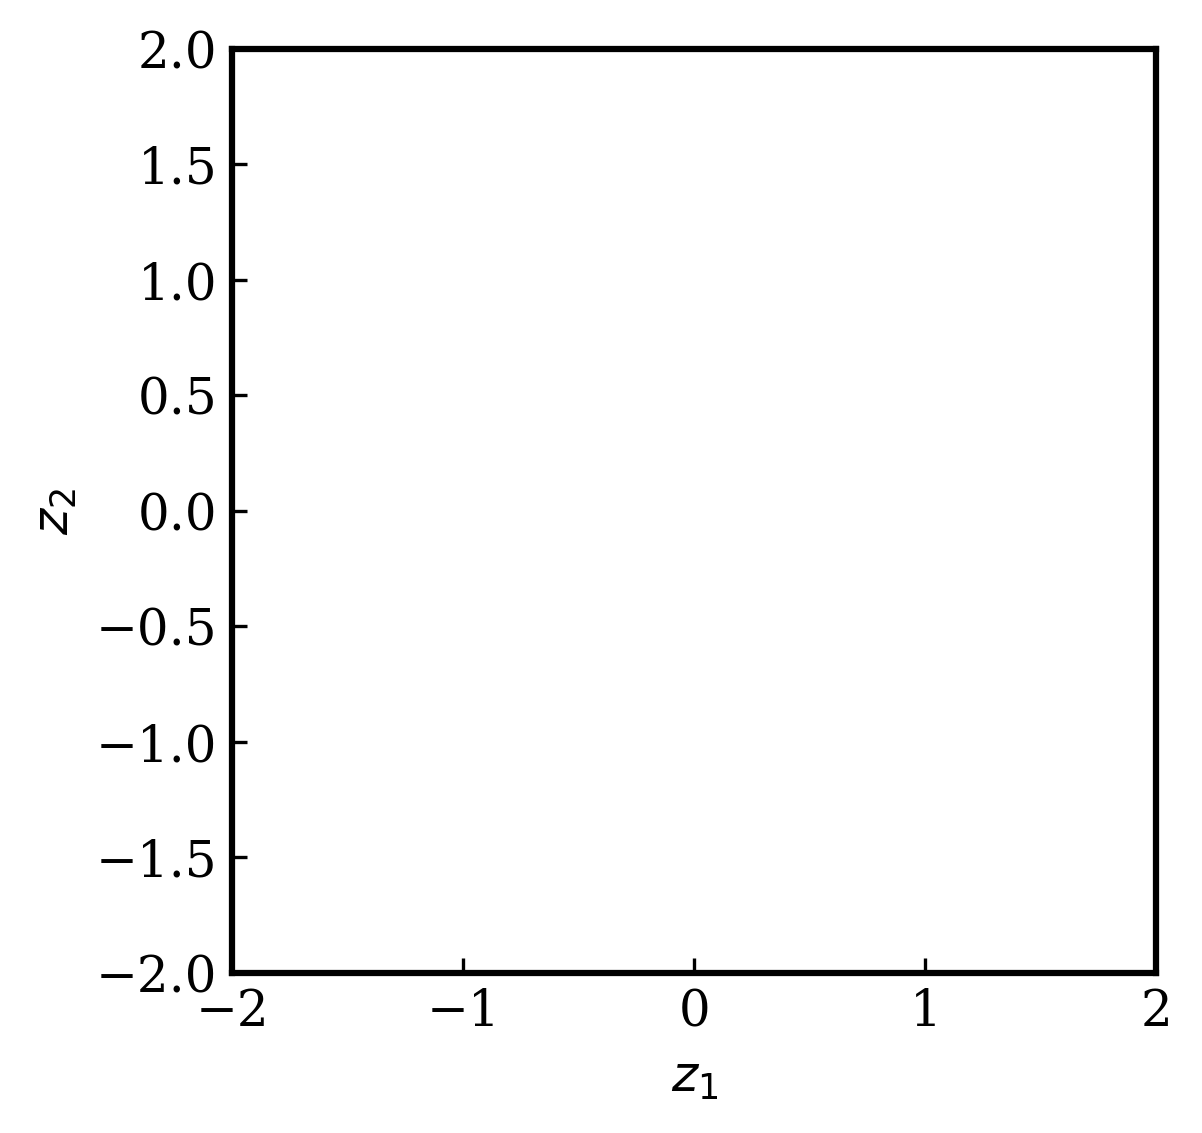

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors

latent_dim = model.latent_dim
grid_size = 50
z_min,z_max = -2,2

resolution = 200

z1 = np.linspace(z_min,z_max,grid_size)
z2 = np.linspace(z_min,z_max,grid_size)

z_grid = np.array(np.meshgrid(z1,z2)).T.reshape(-1,2)

fig,ax = plt.subplots(figsize=(4,4))
ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

ax.set_aspect("equal")
# ax.axis('off')

cmap = cm.viridis  # You can change this to 'plasma', 'coolwarm', etc.

# Compute min/max compactness for color scaling
compactness_values = []
for z in z_grid:
    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0)
    decoded_shape = model.decoder(z_tensor).detach().numpy().reshape(resolution, 2)
    compactness = vae.Metrics(decoded_shape).compute_compactness()
    compactness_values.append(compactness)

compactness_min = np.percentile(compactness_values,5)
compactness_max = np.percentile(compactness_values,95)

# Define normalization
norm = colors.LogNorm(vmin=compactness_min, vmax=compactness_max) 

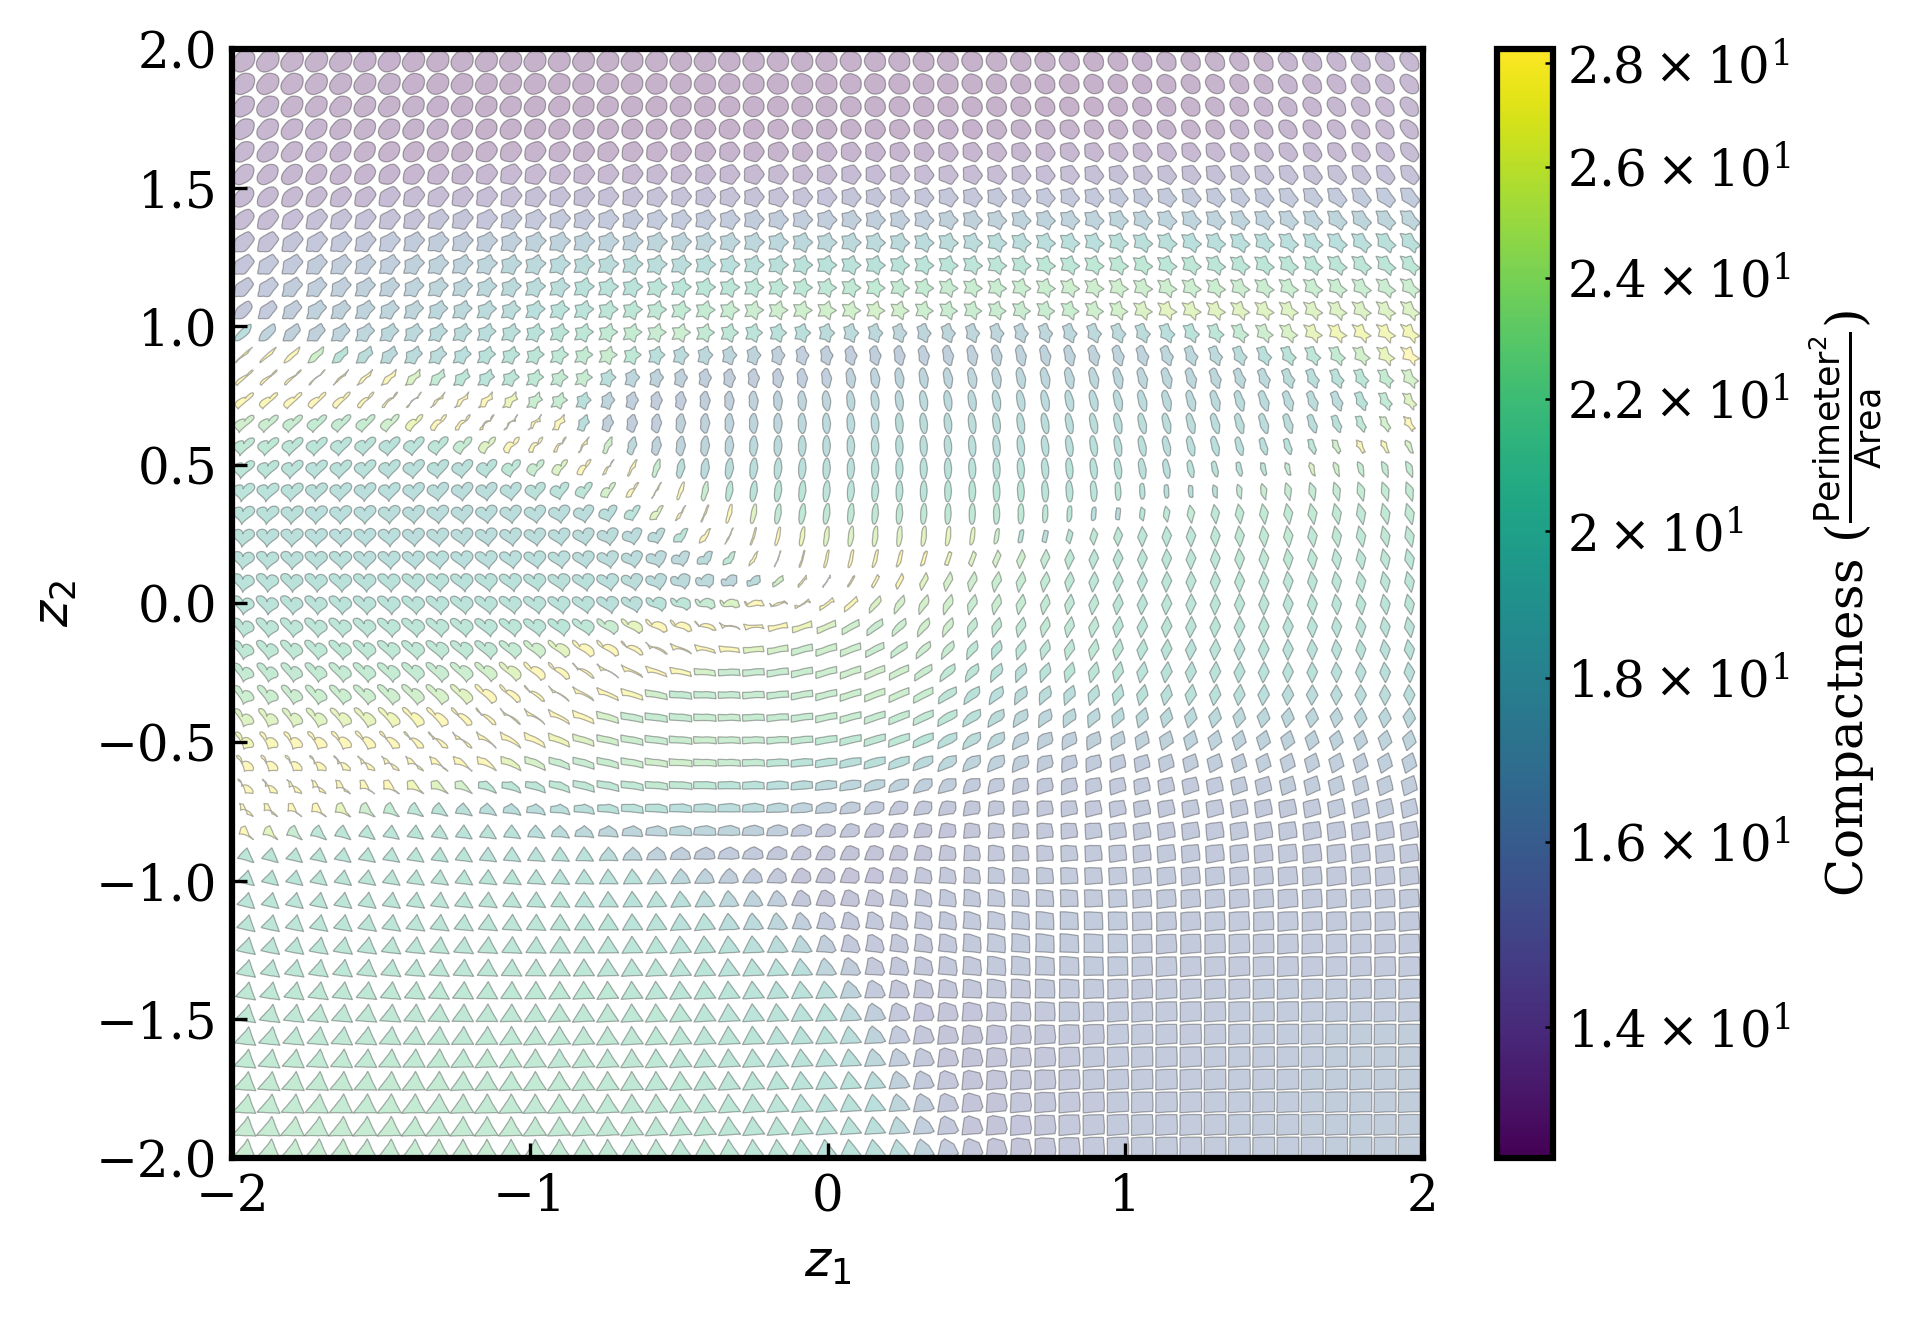

In [28]:
# Create figure and axis
fig, ax = plt.subplots()
ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')


shape_scale = 0.075
for z in z_grid:
    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0)
    decoded_shape = model.decoder(z_tensor).detach().numpy().reshape(resolution, 2)
    
    compactness = vae.Metrics(decoded_shape).compute_compactness()
    decoded_shape *= shape_scale
    
    # Map compactness to an RGBA color tuple
    color_value = cmap(norm(compactness))  # This ensures an RGBA tuple (r, g, b, a)

    # Plot shape
    ax.fill(decoded_shape[:, 0] + z[0], decoded_shape[:, 1] + z[1],
            color=color_value, alpha=0.3, edgecolor='black',linewidth = 0.3)

# Add colorbar reflecting the full compactness range
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"Compactness ($\frac{\text{Perimeter}^2}{\text{Area}}$)")

plt.show()
